In [2]:
import numpy as np
import pandas as pd

In [3]:
import sys, os, re, csv, codecs
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Conv1D, concatenate, Flatten, Concatenate
from tensorflow.keras.layers import  BatchNormalization, Dropout, Activation, SpatialDropout1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers

In [4]:
from sklearn.metrics import hamming_loss
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

In [5]:
multi_train = pd.read_csv('train.csv')

multi_validation = pd.read_csv('dev.csv')

multi_test = pd.read_csv('test.csv')

In [6]:
# change the column names
multi_train.rename(columns={"Ogling/Facial Expressions/Staring": "Staring", "Touching /Groping": "Touching"}, inplace=True)
multi_validation.rename(columns={"Ogling/Facial Expressions/Staring": "Staring", "Touching /Groping": "Touching"},inplace=True)
multi_test.rename(columns={"Ogling/Facial Expressions/Staring": "Staring", "Touching /Groping": "Touching"},inplace=True)

In [7]:
# Drop Duplicates

# keep the first occurance of duplicates for all three datasets and drop the rest

multi_train.drop_duplicates(keep = 'first', inplace=True)
multi_validation.drop_duplicates(keep = 'first', inplace=True)
multi_test.drop_duplicates(keep = 'first', inplace=True)

In [8]:
train = pd.concat([multi_train, multi_validation], axis=0 ) # concat train and validation set 
train.head()

,Description,Commenting,Staring,Touching
0,"Was walking along crowded street, holding mums...",0,0,1
1,This incident took place in the evening.I was ...,0,1,0
2,I WAS WAITING FOR THE BUS. A MAN CAME ON A BIK...,1,0,0
3,Incident happened inside the train,0,0,0
4,I witnessed an incident when a chain was bruta...,0,0,0


In [9]:
test = multi_test  # test set

In [10]:
train.shape, test.shape


((7735, 4), (1640, 4))

In [11]:
y_train = train[['Commenting', 'Staring', 'Touching']].values
y_test = test[['Commenting', 'Staring', 'Touching']].values

In [12]:
# Text Data 
description_train_text =list(train['Description'].values)
description_test_text = list(test['Description'].values)

# tokenize the Text data
tokenizer = tf.keras.preprocessing.text.Tokenizer()
# fit on train data
tokenizer.fit_on_texts(description_train_text)     
# transform train and test data
train_description_sequences = tokenizer.texts_to_sequences(description_train_text)
test_description_sequences = tokenizer.texts_to_sequences(description_test_text)

# vocabulary size 
vocab_size = len(tokenizer.word_index) + 1

# pad the sequnce

train_description_padded = pad_sequences(
        train_description_sequences, maxlen=300, dtype='int32', padding='post',  
        truncating='post')                                                  

test_description_padded = pad_sequences(
        test_description_sequences, maxlen=300, dtype='int32', padding='post', 
        truncating='post')                                  

In [13]:
from gensim.models.fasttext import FastText
%matplotlib inline

In [14]:
import nltk


In [15]:
embedding_size = 300  #  size of the embedding vector. 
window_size = 20    # size of the number of words occurring before and after the word based on which the word representations.
min_word = 5  # minimum frequency of a word in the corpus for which the word representations will be generated
down_sampling = 1e-2   # most frequently occurring word will be down-sampled by a number specified by the down_sampling 
     

In [16]:
word_punctuation_tokenizer = nltk.WordPunctTokenizer()
word_tokenized_corpus = [word_punctuation_tokenizer.tokenize(sent) for sent in description_train_text]
     

In [18]:
embedding_size = 300  # embeddings dimension 
max_input = 300  # padding length        

In [17]:
%%time
ft_model = FastText(word_tokenized_corpus,
                      vector_size=embedding_size,
                      window=window_size,
                      min_count=min_word,
                      sample=down_sampling,
                      sg=1,
                      epochs=100)

CPU times: total: 10min 31s
Wall time: 7min


In [19]:
embedding_matrix_fast_text = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
  try:
    embedding_vector = ft_model.wv[word] # getting the vector for each word
  except:
    embedding_vector = np.zeros(300)
  
  if embedding_vector is not None:
    embedding_matrix_fast_text[i] = embedding_vector

In [32]:
inputs = Input(shape=(max_input,))  # input 
embedding = Embedding(vocab_size, embedding_size, trainable=False) 

embedding.build((None,))
embedding.set_weights([embedding_matrix_fast_text])
embeddings = embedding(inputs)

x = SpatialDropout1D(0.35)(embeddings)

x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.15, recurrent_dropout=0.15))(x)
x = Conv1D(64, kernel_size=3, padding='valid', kernel_initializer='glorot_uniform')(x)

avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)  

x = concatenate([avg_pool, max_pool])

x = BatchNormalization()(x)

x = Dropout(0.2)(x)   

x = Dense(64, activation='relu')(x)

x = Dropout(0.2)(x)   

outputs = Dense(3, activation='sigmoid')(x)  # output

model_4_fast_text = Model(inputs=inputs, outputs = outputs)  # model

In [28]:
model_4_fast_text.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.BinaryAccuracy()])
history = model_4_fast_text.fit(train_description_padded, y_train, batch_size=64, epochs=10, validation_data=(test_description_padded, y_test))  

Epoch 1/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 240s 2s/step - binary_accuracy: 0.6993 - loss: 0.6875 - val_binary_accuracy: 0.6970 - val_loss: 0.6723
Epoch 2/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - binary_accuracy: 0.6961 - loss: 0.6679 - val_binary_accuracy: 0.6970 - val_loss: 0.6558
Epoch 3/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 249s 2s/step - binary_accuracy: 0.7044 - loss: 0.6507 - val_binary_accuracy: 0.6970 - val_loss: 0.6432
Epoch 4/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 246s 2s/step - binary_accuracy: 0.7013 - loss: 0.6388 - val_binary_accuracy: 0.6970 - val_loss: 0.6333
Epoch 5/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 1690s 14s/step - binary_accuracy: 0.6988 - loss: 0.6303 - val_binary_accuracy: 0.6970 - val_loss: 0.6257
Epoch 6/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 251s 2s/step - binary_accuracy: 0.7023 - loss: 0.6211 - val_binary_accuracy: 0.6970 - val_loss: 0.6198
Epoch 7/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 249s 2s/step - binary_accuracy: 0.6986 - loss: 0.6173 - val_binary_accuracy: 0.6970 - val_loss: 0.61

In [30]:
score = model_4_fast_text.evaluate(test_description_padded, y_test, verbose=1)
print("Loss:", score[0])
print("Accuracy:", score[1])

52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - binary_accuracy: 0.6832 - loss: 0.6177
Loss: 0.6075502634048462
Accuracy: 0.6969512104988098


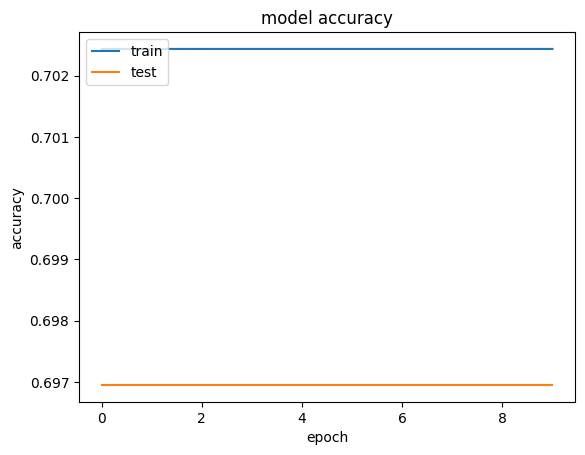

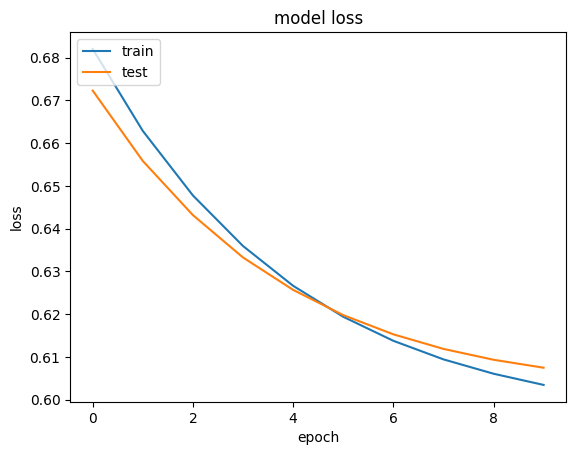

In [36]:
import matplotlib.pyplot as plt
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()